In [187]:
import pandas as pd
import re
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

# Motivation
The Wall Street Journal put out an article on May 31, 2017 with the title [_Though Outnumbered, Female CEOs Earn More Than Male Chiefs_](https://www.wsj.com/articles/women-ceos-dont-get-paid-less-than-men-in-big-business-they-make-more-1496223001). I was intrigued and a bit skeptical and then I noticed they reported the median earnings. Median would normally be a good way to compare but I was curious about the distribution of the compensation since there are only 23 women CEOs at S&P 500 companies this year.

# Data Source
The data was scraped from the AFL-CIO page on CEO compensation using ImportIO to save time on scraping the data.
The format of the URLs was as follows:
- https://aflcio.org/paywatch/highest-paid-ceos?combine=&industry=All&state=All&sp500=0&page=152
- https://aflcio.org/paywatch/highest-paid-ceos?combine=&industry=All&state=All&r3000=0&page=152

I used the link generator tool in [ImportIO](https://www.import.io/) since the page values range from 0 to 152.
I saved the data in both csv and json ('cause why not?) and grabbed the data for the S&P 500 and the Russell 3000 companies (also, why not?). The links above correspond to the S&P 500 (first link) and Russell 3000 (second link).

The data seems to have mixed years and I'm not terribly sure what that means exactly but it was the best data I found in the short amount of time I had to get the analysis done.

## Import the data using Pandas

In [286]:
raw_data = pd.read_csv('Highest_Paid_CEOs_SP500.csv')

In [237]:
raw_data.columns

Index(['﻿"url"', 'Ticker', 'Ticker_link', 'Company', 'Company_link', 'Ceo',
       'Year', 'Compensation'],
      dtype='object')

Here we want to clean up the data a little. First we collect only the relevant columns in to the DataFrame `ceo_pay` and then we need to remove the $ in the compensation column to make the data numeric rather than a string for our analysis later. This gives me a warning about setting a value on a slice of a DataFrame. [I'm not sure what this error means](https://stackoverflow.com/questions/20625582/how-to-deal-with-settingwithcopywarning-in-pandas) but it works nonetheless. While we're editing this data we'll also rescale the compensation to be in units of _Million USD_.

We'll also plop out a quick plot using pandas `plot` function. The y-axis is impossible to read since we'll have all 3000+ CEO names. We're just trying to get a general sense of the distribution before pulling out the top 500 female and male CEOs.

In [250]:
ceo_pay = raw_data[['Ceo','Company', 'Compensation']]
ceo_pay['Compensation'] = ceo_pay['Compensation'].str.replace(r'\$','').str.replace(',','').astype('int')/1e6

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


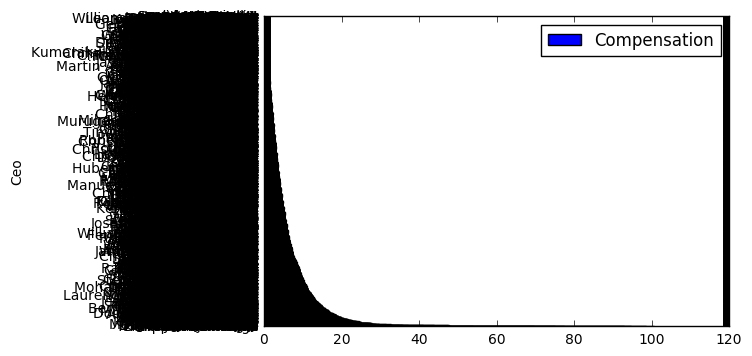

In [251]:
ceo_pay.plot.barh(x='Ceo', y='Compensation')

Before I mentioned that there are 3000+ CEOs in our data. This was unexpected since we thought we were looking at the S&P 500 companies only, but it turns out we've scraped more than that (I'm not sure how since the site only should be giving us the S&P 500 companies and there are no duplicates). We'll fix it later, but first we'll find out how much data we have.

In [37]:
len(raw_data.Ceo.unique())

3031

# Who are the Female CEOs?

## Finding our top female CEOs
I was able to find a list of female ceos from the following sites:

- [Wikipedia](https://en.wikipedia.org/wiki/List_of_women_CEOs_of_Fortune_500_companies)
- [Catalyst](http://www.catalyst.org/knowledge/women-ceos-sp-500?page=1)

The reasoning behind using these two lists was the variation given in the names, i.e., Mary Barra vs. Mary T. Barra or Patti Poppe vs. Patricia K. Poppe. The intention behind using this combined set of names was to maximize the chance of a match when masking the pandas DataFrame to find the data specific to our female CEOS. I copied the lists in and cleaned them up a little by hand. I split the string and cleaned extra spaces. I combined the two lists using a set to remove any duplicates that may be present.

In [285]:
female_ceos1 = 'Mary Barra, Virginia Rometty, Indra K. Nooyi, Marillyn Hewson, Safra A. Catz, Phebe Novakovic,\
Irene B. Rosenfeld, Lynn Good, Shira Goodman, S. Tricia Griffith, Geisha Williams, Vicki Hollub,\
Deanna M. Mulligan, Barbara Rentler, Debra Crew, Anna Manning, Debra L. Reed, Kimberly Lubel, Mary Laschinger,\
Denise M. Morrison, Michele Buck, Sheri S. McCoy, Patti Poppe, Kathleen Mazzarella, Margo Georgiadis, \
Ilene Gordon, Jacqueline C. Hinman'
female_ceos1 = female_ceos1.split(',')
female_ceos1 = [x.strip() for x in female_ceos1]

female_ceos2 = 'Mary T. Barra, Heather Bresch, Michele Buck, Debra A. Cafaro, Safra A. Catz, Debra Crew,\
                Mary Dillon, Adena Friedman, Margaret "Margo" Georgiadis, Lynn J. Good, Shira Goodman,\
                Tricia Griffith, Marillyn A. Hewson, Vicki Hollub, Margaret Keane, Gracia C. Martore,\
                Marissa Mayer, Beth E. Mooney, Denise M. Morrison, Indra K. Nooyi, Phebe N. Novakovic,\
                Patricia K. Poppe, Debra L. Reed, Barbara Rentler, Virginia M. Rometty, Irene B. Rosenfeld,\
                Susan N. Story, Meg Whitman, Geisha Williams'
female_ceos2 = female_ceos2.split(',')
female_ceos2 = [x.strip() for x in female_ceos2]
female_ceos = set(female_ceos1+female_ceos2)
print('Duplicates present: {}\n{} out companies with female CEOs, 23 expected.'.format(len(female_ceos) != len(female_ceos1) + len(female_ceos2), ceo_pay[ceo_pay.Ceo.isin(female_ceos)].shape[0]))

Duplicates present: True
16 out companies with female CEOs, 23 expected.


## Where are the missing CEOs?
We were expecting 23 female CEOs in the data but that's not what we got using the names.

[Fortune](http://beta.fortune.com/fortune500/list/filtered?ceowoman=true)

In [132]:
# Copied and pasted this off a website (used the checker below to determine which names agreed.
# If they didn't I fixed them up here. I added the semicolons to allow me to split the string)
companies_w_female_ceo = 'General Motors Company$152,356;\
31International Business Machines Corporation$82,461\
;44Pepsico$63,056\
;60Lockheed Martin Corporation$46,132\
;77Oracle Corporation$38,226\
;88General Dynamics Corporation$31,469\
;94Mondelez International$29,636\
;115Duke Energy Corporation$24,002\
;150Xerox Corporation$18,664\
;225Occidental Petroleum Corporation$12,699\
;226Guardian Life Ins. Co. of America$12,628\
;237Ross Stores$11,940\
;266Reynolds American$10,675\
;269Hertz Global Holdings$10,535\
;271Reinsurance Group of America$10,418\
;279Sempra Energy$10,231\
;299CST Brands$9,499\
;323Veritiv Corporation$8,718\
;337Campbell Soup Company$8,082\
;370Avon Products$7,173\
;423Graybar Electric$6,110\
;456Ingredion$5,621\
;478CH2M Hill$5,362'

companies_w_female_ceo = companies_w_female_ceo.split(';')
companies_w_female_ceo = [re.sub(r'^\d{2,3}', '', x) for x in companies_w_female_ceo]
companies_w_female_ceo = [re.sub(r'\$\d+,\d+$', '', x) for x in companies_w_female_ceo]

In [140]:
#Check to see what's missing
list(filter(lambda x: x not in list(ceo_pay.Company.unique()), companies_w_female_ceo))
#can't find these 3 in the data :(

['Guardian Life Ins. Co. of America', 'Graybar Electric', 'CH2M Hill']

In [156]:
# Who is in the data
list(ceo_pay.Ceo[ceo_pay['Company'].isin(companies_w_female_ceo)].unique())

['Mark V. Hurd',
 'V.M. Rometty',
 'Indra K. Nooyi',
 'Mary T. Barra',
 'Phebe N. Novakovic',
 'Marillyn A. Hewson',
 'Irene Rosenfeld',
 'Ursula M. Burns',
 'Lynn J. Good',
 'Susan M. Cameron',
 'Vicki Hollub',
 'Denise M. Morrison',
 'Barbara Rentler',
 'A. Greig Woodring',
 'Debra L. Reed',
 'Ilene S. Gordon',
 'Mary A. Laschinger',
 'Sheri McCoy',
 'Kimberly S. Lubel',
 'John P. Tague']

In [157]:
#Who is missing from the data
list(filter(lambda x: x not in list(ceo_pay.Ceo[ceo_pay['Company'].isin(companies_w_female_ceo)].unique()), female_ceos))

['Patricia K. Poppe',
 'Kathleen Mazzarella',
 'Irene B. Rosenfeld',
 'Shira Goodman',
 'Michele Buck',
 'Margo Georgiadis',
 'Deanna M. Mulligan',
 'Lynn Good',
 'Susan N. Story',
 'Meg Whitman',
 'Heather Bresch',
 'S. Tricia Griffith',
 'Virginia M. Rometty',
 'Beth E. Mooney',
 'Phebe Novakovic',
 'Tricia Griffith',
 'Adena Friedman',
 'Safra A. Catz',
 'Jacqueline C. Hinman',
 'Debra Crew',
 'Virginia Rometty',
 'Mary Laschinger',
 'Sheri S. McCoy',
 'Gracia C. Martore',
 'Patti Poppe',
 'Margaret "Margo" Georgiadis',
 'Debra A. Cafaro',
 'Ilene Gordon',
 'Kimberly Lubel',
 'Mary Dillon',
 'Mary Barra',
 'Marissa Mayer',
 'Margaret Keane',
 'Anna Manning',
 'Marillyn Hewson',
 'Geisha Williams']

## Whomp, Whomp
Some of these names don't agree with the more current data. So I'll assume the new CEOs are paid the same. The Oracle CEO is a co-CEO so that's probably okay as is.

In [255]:
# Define new dataframes and limit the male ceo one to the remainder of the top 500 since we've 
# restricted female ceo to top 500 as well
female_ceo_pay = ceo_pay[ceo_pay['Company'].isin(companies_w_female_ceo)]
male_ceo_pay = ceo_pay[~ceo_pay['Company'].isin(companies_w_female_ceo)][:500-len(female_ceo_pay)]
graph_male_pay  = male_ceo_pay[::25]

In [256]:
female_ceo_pay.Compensation.describe()

count    20.000000
mean     16.052925
std       9.462020
min       5.077351
25%      10.326090
50%      13.223516
75%      20.769819
max      41.121896
Name: Compensation, dtype: float64

In [257]:
male_ceo_pay.Compensation.describe()

count    480.000000
mean      16.456374
std       10.619200
min        9.748332
25%       11.291432
50%       13.470003
75%       17.719189
max      100.632102
Name: Compensation, dtype: float64

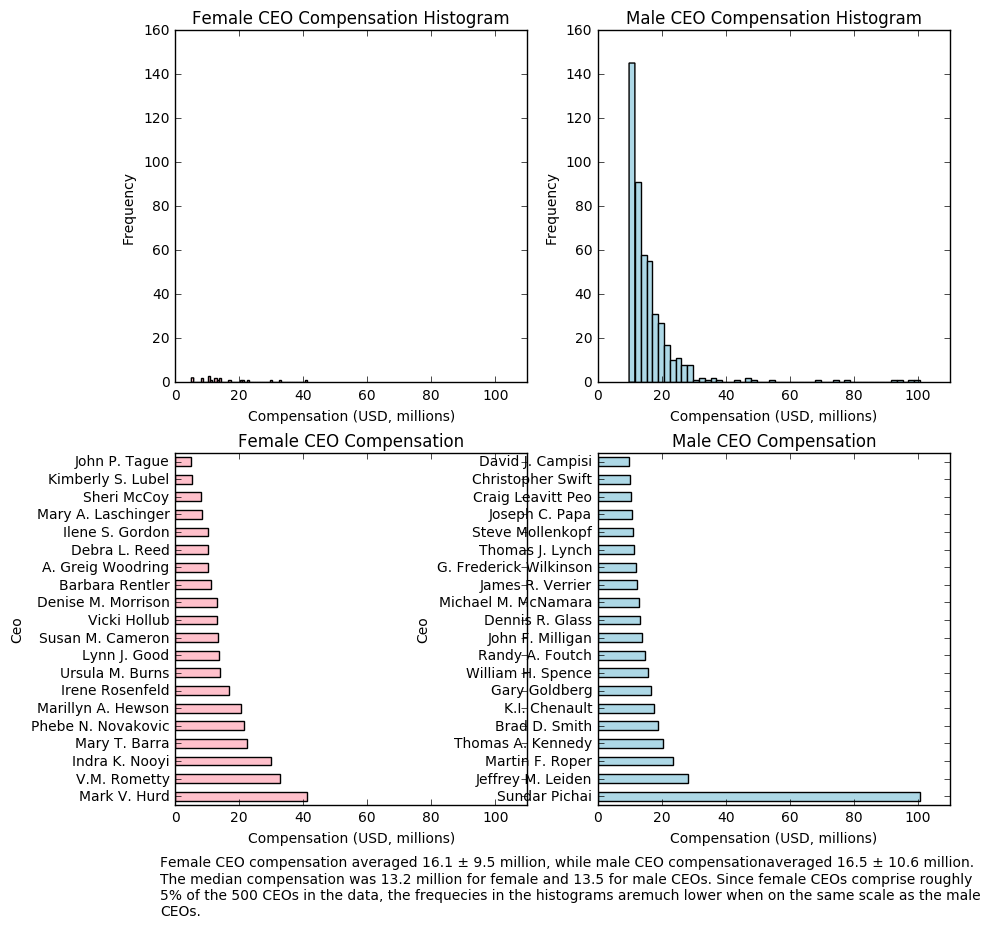

In [272]:
x_axis = (0, round(max([male_ceo_pay.Compensation.max(), female_ceo_pay.Compensation.max()]),0)+\
          (10 - round(max([male_ceo_pay.Compensation.max(), female_ceo_pay.Compensation.max()]),0)%10))
x_label = 'Compensation (USD, millions)'
title = 'Comparison of Male and Female CEO Compensation for Companies in the S&P 500'
caption = 'Female CEO compensation averaged {} \u00B1 {} million, while male CEO compensation\
averaged {} \u00B1 {} million.\nThe median compensation was {} million for female and {} for male CEOs. \
Since female CEOs comprise roughly\n5% of the 500 CEOs in the data, the frequecies in the histograms are\
much lower when on the same scale as the male\nCEOs.'.format(\
        round(female_ceo_pay.Compensation.mean(),1),round(female_ceo_pay.Compensation.std(),1),\
        round(male_ceo_pay.Compensation.mean(),1),round(male_ceo_pay.Compensation.std(),1),\
        round(female_ceo_pay.Compensation.median(),1), round(male_ceo_pay.Compensation.median(),1))

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10))

female_ceo_pay.plot.hist(y='Compensation', color='pink',bins= 50, ylim=(0,160),legend=False,\
                         xlim=x_axis, ax=axes[0,0]); axes[0,0].set_title('Female CEO Compensation Histogram');

male_ceo_pay.plot.hist( y='Compensation', color='lightblue', bins=50,ylim=(0,160),legend=False,\
                       xlim=x_axis, ax=axes[0,1]); axes[0,1].set_title('Male CEO Compensation Histogram');

female_ceo_pay.plot.barh(x='Ceo', y='Compensation', color='pink',legend=False,\
                         xlim=x_axis, ax=axes[1,0]); axes[1,0].set_title('Female CEO Compensation');

graph_male_pay.plot.barh(x='Ceo', y='Compensation', color='lightblue', legend=False,\
                       xlim=x_axis, ax=axes[1,1]); axes[1,1].set_title('Male CEO Compensation');

fig.set_facecolor('white')
fig.title=(title)
axes[0,0].set_xlabel(x_label)
axes[0,1].set_xlabel(x_label)
axes[1,0].set_xlabel(x_label)
axes[1,1].set_xlabel(x_label)
fig.text(0.11,0.015,caption)